# Assignment 3b code

Members of the team:

- Chinmay Dharmik | a1855351
- Harpreet Kaur Hans | a1873328
- Priyank Dave | a1843068

Group 1

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

train_data = pd.read_csv('Groceries data train.csv')
test_data = pd.read_csv('Groceries data test.csv')

train_data.head()


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


# Visualization (Data Exploration)

In [43]:
total_items = len(train_data)
total_days = len(np.unique(train_data.Date))
total_months = len(np.unique(train_data.month))
average_items = total_items / total_days
unique_items = train_data.itemDescription.unique().size

print("There are {} unique items sold ".format(unique_items))
print("Total {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print("With an average of {} items sold daily".format(average_items))

There are 167 unique items sold 
Total 27000 items sold in 728 days throughout 12 months
With an average of 37.08791208791209 items sold daily


In [44]:
train_data = train_data.drop(["year","month","day","day_of_week"],axis = 1)
test_data = test_data.drop(["year","month","day","day_of_week"],axis = 1)

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

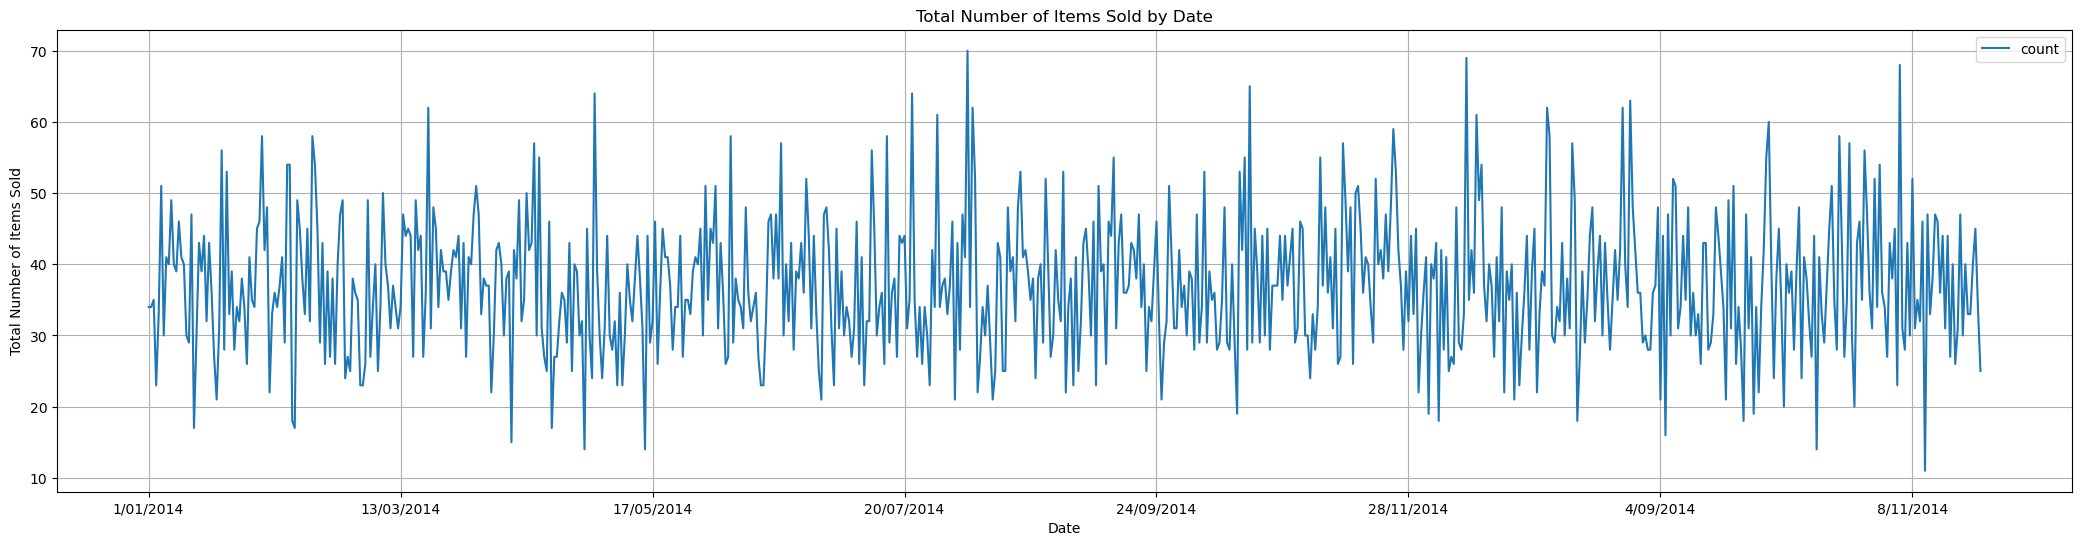

In [45]:
train_data.groupby(['Date'])['itemDescription'].agg(['count']).plot(figsize=(26,6), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")

/tmp/ipykernel_18141/1222990326.py:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items Sold')]

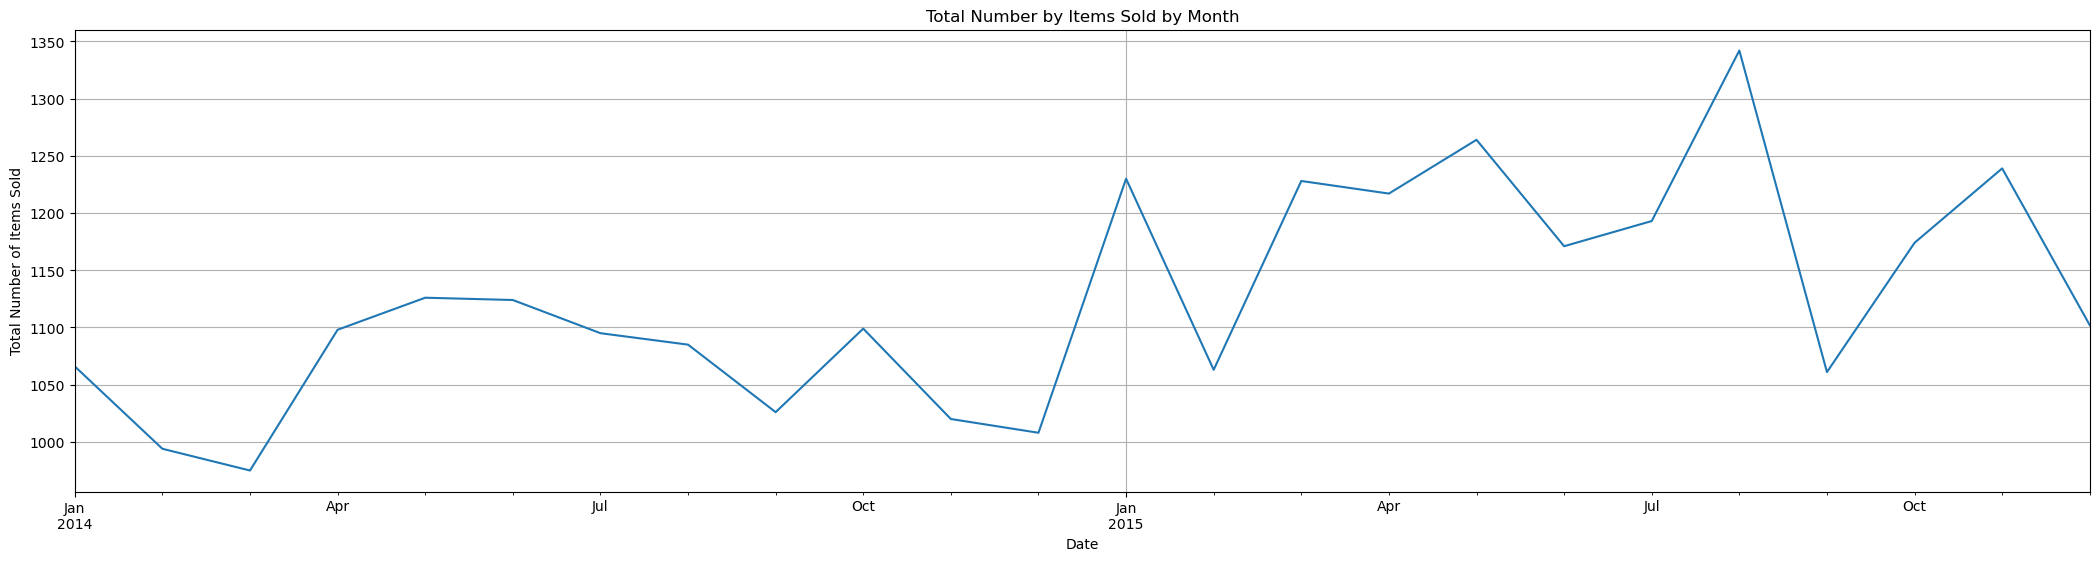

In [46]:
train_data=train_data.set_index(['Date'])
train_data.index=pd.to_datetime(train_data.index)
train_data.resample("M")['itemDescription'].count().plot(figsize=(26,6), grid=True, title="Total Number by Items Sold by Month").set(xlabel="Date", ylabel="Total Number of Items Sold")

In [47]:
import plotly.express as px
def bar_graph(df,col):

    fig = px.bar(df,
        x = df[col].value_counts().keys(), 
        y = df[col].value_counts().values,
        color= df[col].value_counts().keys()
    )
    fig.update_layout(
    xaxis_title= col,
    yaxis_title="Count",
    legend_title=col,
    font_family="Times New Roman",
    font_color="blue",
    title_font_family="Calibri",
    title_font_color="red",
    legend_title_font_color="green"
)
    
    fig.show()

In [48]:
bar_graph(train_data,'itemDescription')

In [49]:
bar_graph(test_data,'itemDescription')

# Individual codes for Assignment 3

## Task 1

In [50]:
"""
Author: Priyank Dave
Group: 1
Task: 1

Description:
This script performs pattern mining on a dataset of grocery store transactions using the Apriori algorithm.
It reads in a CSV file of transaction data and extracts the item descriptions, then converts the data into
a transaction array using the mlxtend library's TransactionEncoder. The Apriori algorithm is used to find
frequent itemsets and association rules, and the results are stored in a pandas DataFrame. The class provides
methods for accessing the patterns found by the algorithm as well as for printing out the data, transaction
array, item frequency, and patterns.

Usage:
Create an instance of the PatternMining class with the filename of the transaction data CSV file as an argument,
then call the get_patterns() method to access the patterns found by the Apriori algorithm. To print out the data,
transaction array, item frequency, and patterns, simply print the PatternMining instance.

Example:
pattern_mining = PatternMining('./Groceries data train.csv')
patterns = pattern_mining.get_patterns()
print(patterns)
print(pattern_mining)

Requirements:
- numpy
- pandas
- mlxtend
"""

import sys
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

class PatternMining:
    def __init__(self, file_name):
        # Initialize the class with the data file name and create necessary variables
        self.data = pd.read_csv(file_name, usecols=['Member_number', 'Date', 'itemDescription'])
        self.transaction_array = self._get_transaction_array()
        self.item_frequency = self._get_item_frequency()
        self.patterns = self._apriori()

    def _get_transaction_array(self):
        # Convert the data into a transaction array using TransactionEncoder
        transactions = [a[1]['itemDescription'].tolist() for a in list(self.data.groupby(['Member_number', 'Date']))]
        te = TransactionEncoder()
        tran_arr = te.fit(transactions).transform(transactions)
        transaction_array = pd.DataFrame(tran_arr, columns=te.columns_)
        return transaction_array

    def _get_item_frequency(self):
        # Get the frequency of each item in the dataset
        item_frequency = pd.DataFrame(self.data['itemDescription'].value_counts())
        return item_frequency

    def _apriori(self):
        # Use the apriori algorithm to find frequent itemsets and association rules
        patterns = apriori(self.transaction_array, min_support=0.001, use_colnames=True, verbose=1)
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = association_rules(patterns, metric="confidence",min_threshold=0.001)
        return patterns

    def get_patterns(self):
        # Return the patterns found by the apriori algorithm
        return self.patterns
    
    def recommend(self, purchased_items, num_items=5):
        # Get the frequent itemsets that contain the purchased items
        itemsets = self.patterns[self.patterns['antecedents'] == set(purchased_items)]
        # Sort the itemsets by confidence in descending order
        itemsets = itemsets.sort_values(by='confidence', ascending=False)
        
        # Get the recommended items from the top itemsets
        recommended_items = []
        for itemset in itemsets['consequents']:
            for item in itemset:
                if item not in purchased_items and item not in recommended_items:
                    recommended_items.append(item)
                if len(recommended_items) >= num_items:
                    break
            if len(recommended_items) >= num_items:
                break
                
        return recommended_items

    def __repr__(self) -> str:
        # Print out the data, transaction array, item frequency, and patterns found by the apriori algorithm
        return f'''The data structure is \n {self.data.head(10)} \n\n\n 
        transaction array is \n {self.transaction_array.head(10)} \n\n\n 
        item frequency is \n {self.item_frequency.head(10)} \n\n\n 
        patterns are \n {self.patterns.tail(10)} \n\n\n
        '''

## Task 2

In [51]:
"""
Assignment 3 Mining Big Data

Author: Harpreet Kaur Hans
Group: 1
Task: 2
This code defines a class nn_recommender for a nearest neighbors-based recommender that takes a CSV file with shopping data as input. The shopping data is transformed into a frequency table where each row corresponds to a member and each column corresponds to an item in the store catalog. The recommender uses a nearest neighbors model to find the 5 most similar members to a given query, and recommends the items they bought that the query member hasn't. 

The class has the following methods:
- __init__(self, filename): Constructor that loads the data, transforms it into a frequency table, fits a nearest neighbors model, and stores it.
- load_data(self): Method that transforms the input data into a frequency table (dataframe).
- recommender(self, query): Method that recommends items based on a query. It takes a set of item names as input and returns a list of recommended item names.

To use the class, create an instance of the nn_recommender class with the filename of the shopping data CSV file as input. Then, call the recommender method with a set of item names to get a list of recommended item names.
"""

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Define a class for a nearest neighbors-based recommender
class nn_recommender():
    
    # Constructor that loads the data, fits a nearest neighbors model, and stores it
    def __init__(self, filename):
        # Load data from a CSV file with columns 'Member_number', 'Date', 'itemDescription'
        self.shopperdata = pd.read_csv(filename, usecols=['Member_number', 'Date', 'itemDescription'])
        # Transform the data into a frequency table (dataframe)
        self.data = self.load_data()
        # Create a nearest neighbors model with 5 neighbors and 'ball_tree' algorithm
        self.model = NearestNeighbors(n_neighbors=5, algorithm='auto')
        # Fit the model with the transformed data
        self.model.fit(self.data)
    
    # Method to transform the input data into a frequency table (dataframe)
    def load_data(self):
        data = self.shopperdata
        # Group the data by 'Member_number' and count the frequency of each 'itemDescription'
        # The result is a list of tuples, where each tuple contains a member ID and a frequency dictionary
        tmp = [(i[0], (i[1]['itemDescription']).value_counts()) for i in list(data.groupby('Member_number'))]
        
        # Extract the column names from the Pandas Series objects
        column_names = set()
        for _, series in tmp:
            column_names.update(series.index)
        column_names = sorted(column_names)

        # Create a Pandas DataFrame with columns as the unique 'itemDescription's and rows as the members
        freq_df = pd.DataFrame(columns=column_names)

        # Add the frequency data to the DataFrame
        for id, series in tmp:
            freq_df.loc[id] = [series.get(column_name, 0) for column_name in column_names]
        return freq_df
    
    # Method to recommend items based on a query
    def recommend(self, query):
        # Create a dictionary with keys as the unique 'itemDescription's and values as 0s
        ques = dict(zip(list(self.model.feature_names_in_), np.zeros(len(self.model.feature_names_in_))))
        # For each item in the query, set its value to 1 in the dictionary if it exists in the unique 'itemDescription's
        for i in query:
            if i not in self.model.feature_names_in_:
                #print(f"{i} not in store catalogue \n dropping the item")
                continue
            ques[i] = 1
        # Create a Pandas DataFrame with the dictionary as a row
        ques = pd.DataFrame(data=ques, index=[0])
        # Find the 5 nearest neighbors to the query in the transformed data and return their indices
        distances, indices = self.model.kneighbors(ques)
        # Return the recommended items, which are the rows in the transformed data corresponding to the nearest neighbors
        rec = []
        for i in indices.flatten():
            rec.extend(self.data.iloc[i][self.data.iloc[i].eq(1, axis=0)].index.tolist())
        rec = list(set(rec))
        return rec


## Task 3

In [52]:
"""
This Python file implements the FP-growth algorithm to mine frequent itemsets and generate association rules. The FPgrowth class takes a CSV file containing transaction data as input, and outputs the frequent itemsets and association rules that can be used to make recommendations. The class also contains a recommend method that takes a set of purchased items and returns a list of recommended items based on the association rules generated.

The FP-growth algorithm is implemented using the mlxtend library, which provides efficient and easy-to-use implementations of various data mining algorithms. The code is written in Python and requires the following libraries: numpy, pandas, and mlxtend.

Please make sure that the input CSV file has the following columns: Member_number, Date, and itemDescription.

To use this code, simply create an instance of the FPgrowth class, passing in the path to the CSV file containing the transaction data. Then, you can call the get_patterns method to retrieve the frequent itemsets and association rules, or the recommend method to get recommendations based on the association rules.

Author: Chinmay Dharmik | a1855351 
Group: 1 
Task: 3

Assignment 3 Mining Big Data

"""

# IMPORT LIBRARIES
import sys
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns.fpgrowth import fpgrowth
from mlxtend.frequent_patterns import association_rules

class FPgrowth:
    """
    A class to perform association rule mining using the FP-growth algorithm.

    Attributes
    ----------
    data : pandas.DataFrame
        The input data read from the file.
    transaction_array : pandas.DataFrame
        The transaction array obtained by transforming the data using TransactionEncoder.
    patterns : pandas.DataFrame
        The patterns obtained by applying the FP-growth algorithm to the transaction array.

    Methods
    -------
    _get_transaction_array():
        Converts the input data into a transaction array using TransactionEncoder.
    _fp_growth():
        Applies the FP-growth algorithm to the transaction array and returns the resulting patterns.
    get_patterns():
        Returns the patterns found by the FP-growth algorithm.
    recommend(purchased_items, num_items=2):
        Recommends items to the user based on the purchased items using the association rules.

    """

    def __init__(self, file_name):
        """
        Initializes the FPgrowth object with the data file name.

        Parameters
        ----------
        file_name : str
            The name of the file containing the input data.
        """
        self.data = pd.read_csv(file_name, usecols=['Member_number', 'Date', 'itemDescription'])
        self.transaction_array = self._get_transaction_array()
        self.patterns = self._fp_growth()

    def _get_transaction_array(self):
        """
        Converts the input data into a transaction array using TransactionEncoder.

        Returns
        -------
        pandas.DataFrame
            The transaction array obtained by transforming the input data using TransactionEncoder.
        """ 
        transactions = [a[1]['itemDescription'].tolist() for a in list(self.data.groupby(['Member_number', 'Date']))] # ref [2]
        te = TransactionEncoder()
        tran_arr = te.fit(transactions).transform(transactions)
        transaction_array = pd.DataFrame(tran_arr, columns=te.columns_)
        return transaction_array
    
    def _fp_growth(self):
        """
        Applies the FP-growth algorithm to the transaction array and returns the resulting patterns.

        Returns
        -------
        pandas.DataFrame
            The patterns obtained by applying the FP-growth algorithm to the transaction array.
        """
        frequent_itemsets = fpgrowth(self.transaction_array, min_support=0.001, use_colnames = True) # ref [1]
        patterns = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001) # ref [1]
        return patterns
    
    def get_patterns(self):
        """
        Returns the patterns found by the FP-growth algorithm.

        Returns
        -------
        pandas.DataFrame
            The patterns obtained by applying the FP-growth algorithm to the transaction array.
        """
        return self.patterns
    
    def recommend(self, purchased_items, num_items=5):
        """
        Recommends items to the user based on the purchased items using the association rules.

        Parameters
        ----------
        purchased_items : set
            The set of items that the user has purchased.
        num_items : int, optional
            The maximum number of items to recommend. Default is 2.

        Returns
        -------
        list
            The list of recommended items.
        """
        # Get the frequent itemsets that contain the purchased items
        itemsets = self.patterns[self.patterns['antecedents'] == set(purchased_items)]
        # Sort the itemsets by confidence in descending order
        itemsets = itemsets.sort_values(by='confidence', ascending=False)
        
        # Get the recommended items from the top itemsets
        recommended_items = []
        for itemset in itemsets['consequents']:
            for item in itemset:
                if item not in purchased_items and item not in recommended_items:
                    recommended_items.append(item)
                if len(recommended_items) >= num_items:
                    break
            if len(recommended_items) >= num_items:
                break
        return recommended_items

    def __repr__(self):
        """
        Return a string representation of the object.
        
        Returns:
        str: A string representation of the object.
        """
        return f'''The data structure is \n {self.data.head(10)} \n\n\n 
        transaction array is \n {self.transaction_array.head(10)} \n\n\n  
        patterns are \n {self.patterns.tail(10)} \n\n\n
        '''

"""
Sources: 
[1] https://towardsdatascience.com/the-fp-growth-algorithm-1ffa20e839b8
[2] https://deepak6446.medium.com/apriori-algorithm-in-python-recommendation-engine-5ba89bd1a6da
[3] https://github.com/JackHCC/Apriori-and-FP_Growth/blob/9bb3c7d9498980e857889e4ea6e8344781b21f61/FP_growth.py#L10 ---> used to understand the algorithm
"""


'\nSources: \n[1] https://towardsdatascience.com/the-fp-growth-algorithm-1ffa20e839b8\n[2] https://deepak6446.medium.com/apriori-algorithm-in-python-recommendation-engine-5ba89bd1a6da\n[3] https://github.com/JackHCC/Apriori-and-FP_Growth/blob/9bb3c7d9498980e857889e4ea6e8344781b21f61/FP_growth.py#L10 ---> used to understand the algorithm\n'

# Testing the Models

### Testing the runtime of the models

In [53]:
Time_Analysis = list()
apriori_time = dict()
apriori_time['model']= 'apriori'
apriori_time['start_time'] = time.time()
Apriori = PatternMining('Groceries data train.csv')
apriori_time['end_time'] = time.time()

knn_time = dict()
knn_time['model'] = 'knn'
knn_time['start_time'] = time.time()
knn=nn_recommender('Groceries data train.csv')
knn_time['end_time'] = time.time()

fpg_time = dict()
fpg_time['model']= 'fpgrowth'
fpg_time['start_time'] = time.time()
fpg = FPgrowth('Groceries data train.csv')
fpg_time['end_time'] = time.time()


Processing 8028 combinations | Sampling itemset size 32


### Most Frequenct Items

In [54]:
Apriori.item_frequency.head(10)

,itemDescription
whole milk,1709
other vegetables,1320
rolls/buns,1197
soda,1060
yogurt,928
root vegetables,733
tropical fruit,683
bottled water,666
sausage,637
citrus fruit,560


/home/kyrotron/miniconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/home/kyrotron/miniconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/home/kyrotron/miniconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/home/kyrotron/miniconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/home/kyrotron/miniconda3/lib/python3.10/site-packages/wordcloud/

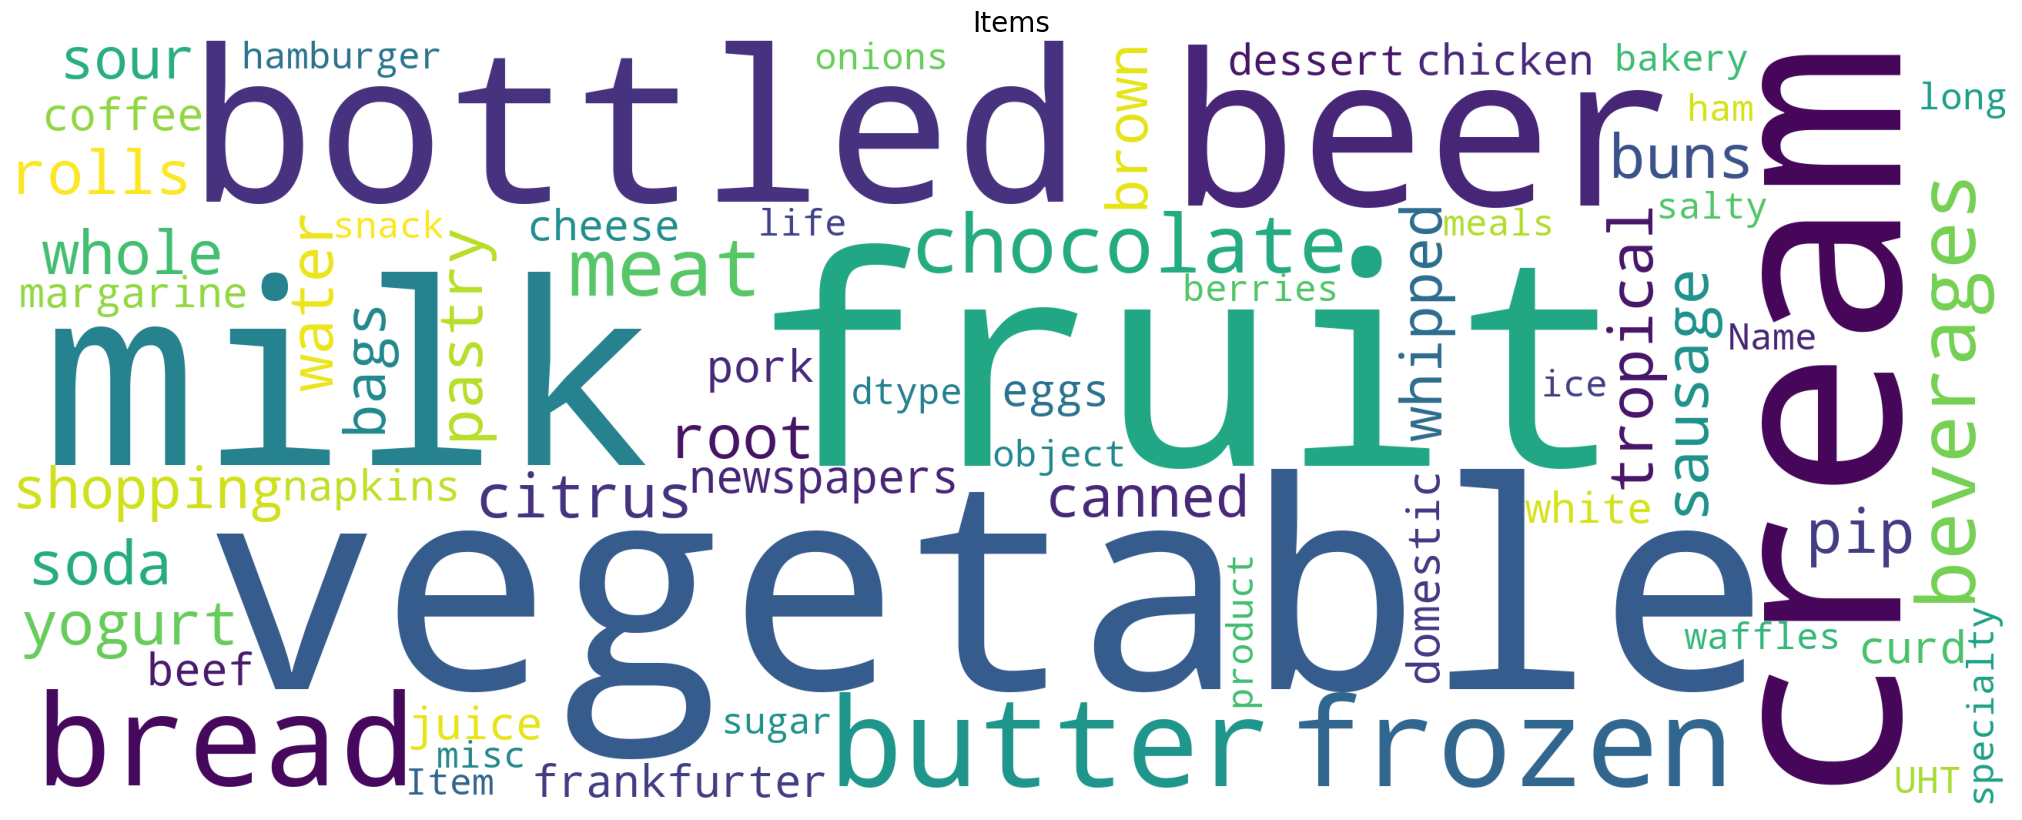

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
item = Apriori.transaction_array.describe()
f = item.iloc[0]-item.iloc[3]
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False).head(50)


plt.rcParams['figure.figsize'] = (26, 10)
wordcloud = WordCloud(background_color = 'white', width = 2600,  height = 1000, max_words = 121).generate(str(item['Item']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Items',fontsize = 20)
plt.show()


In [56]:
fig = px.treemap(item, path=['Item'], values='Count')
fig.show()

In [57]:
fig=px.scatter(Apriori.get_patterns()['support'], Apriori.get_patterns()['confidence'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="confidence",
   
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Confidence (Apriori)')
    
)

fig.show()

In [58]:
fig=px.scatter(fpg.get_patterns()['support'], fpg.get_patterns()['confidence'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="confidence",
   
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Confidence (FP Growth)')
    
)

fig.show()

Text(0.5, 1.0, 'lift vs Confidence (Apriori)')

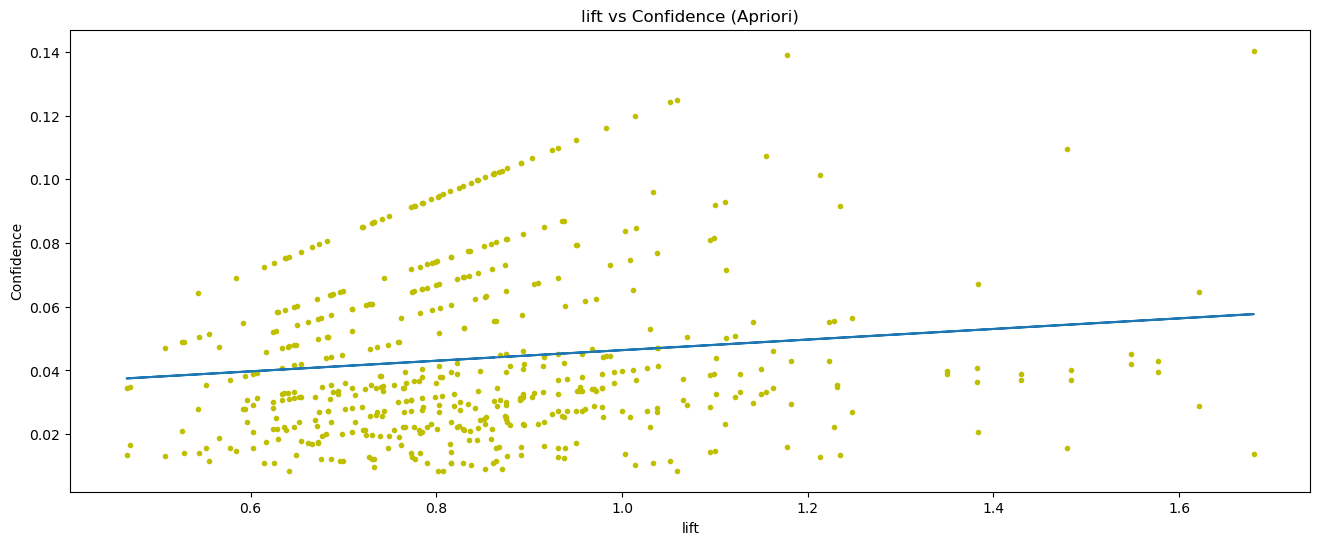

In [59]:
fit = np.polyfit(Apriori.get_patterns()['lift'], Apriori.get_patterns()['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(16,6))
plt.plot(Apriori.get_patterns()['lift'], Apriori.get_patterns()['confidence'], 'y.', Apriori.get_patterns()['lift'], 
fit_fn(Apriori.get_patterns()['lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence (Apriori)')

Text(0.5, 1.0, 'lift vs Confidence (FP Growth)')

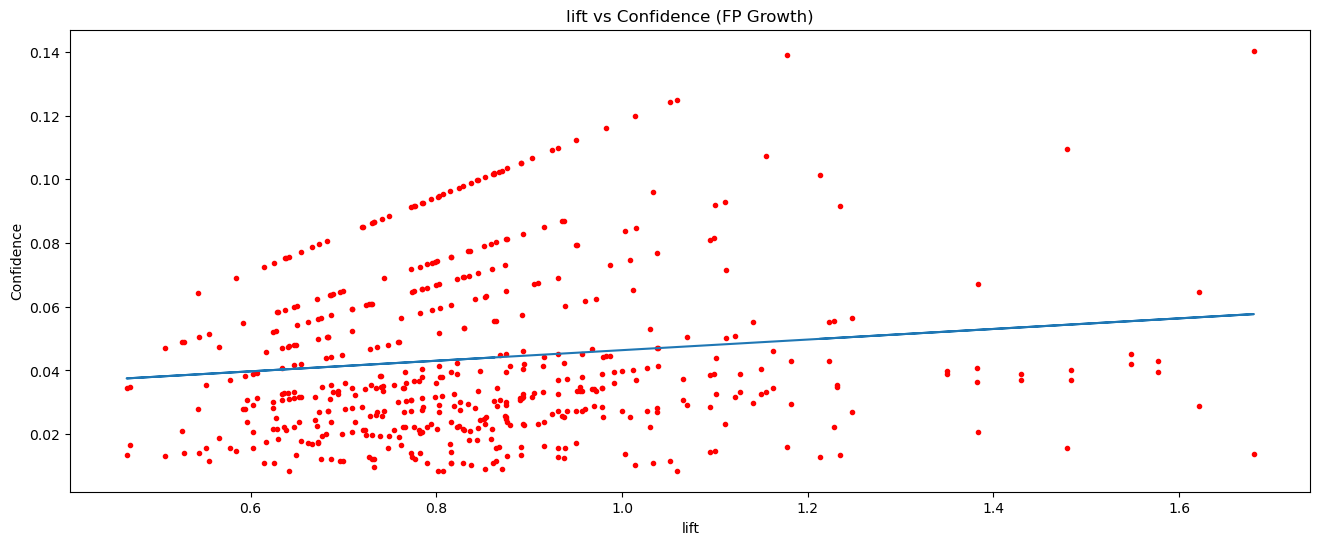

In [60]:
fit = np.polyfit(fpg.get_patterns()['lift'], fpg.get_patterns()['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.figure(figsize=(16,6))
plt.plot(fpg.get_patterns()['lift'], fpg.get_patterns()['confidence'], 'r.', fpg.get_patterns()['lift'], 
fit_fn(fpg.get_patterns()['lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence (FP Growth)')

### Testing the performance of the different algorithms

5 frequent Patterns APRIORI

In [61]:
FP = Apriori.get_patterns().sort_values('support',ascending=False)
print(FP[['antecedents','consequents','support','confidence']].head(5))
# TRAIN DATA

            antecedents         consequents   support  confidence
453        (whole milk)        (rolls/buns)  0.007913    0.067032
452        (rolls/buns)        (whole milk)  0.007913    0.094746
386        (whole milk)  (other vegetables)  0.006978    0.059110
387  (other vegetables)        (whole milk)  0.006978    0.075194
517            (yogurt)        (whole milk)  0.006546    0.101790


In [62]:
ap_test = PatternMining('./Groceries data test.csv')
FP = ap_test.get_patterns().sort_values('support',ascending=False)
print(FP[['antecedents','consequents','support','confidence']].head(5))
# TEST DATA

Processing 216 combinations | Sampling itemset size 3 2
           antecedents         consequents   support  confidence
27  (other vegetables)        (whole milk)  0.003306    0.050611
26        (whole milk)  (other vegetables)  0.003306    0.037132
36        (whole milk)        (rolls/buns)  0.002850    0.032010
37        (rolls/buns)        (whole milk)  0.002850    0.048356
19  (other vegetables)        (rolls/buns)  0.002736    0.041885


5 frequent Patterns FP Growth

In [63]:
FP = fpg.get_patterns().sort_values('support',ascending=False)
print(FP[['antecedents','consequents','support','confidence']].head(5))
# TRAIN DATA

            antecedents         consequents   support  confidence
83         (whole milk)        (rolls/buns)  0.007913    0.067032
82         (rolls/buns)        (whole milk)  0.007913    0.094746
197  (other vegetables)        (whole milk)  0.006978    0.075194
196        (whole milk)  (other vegetables)  0.006978    0.059110
0          (whole milk)            (yogurt)  0.006546    0.055454


In [64]:
fpg_test = FPgrowth('./Groceries data test.csv')
FP = fpg_test.get_patterns().sort_values('support',ascending=False)
print(FP[['antecedents','consequents','support','confidence']].head(5))
# TEST DATA

          antecedents         consequents   support  confidence
2        (whole milk)  (other vegetables)  0.003306    0.037132
3  (other vegetables)        (whole milk)  0.003306    0.050611
4        (whole milk)        (rolls/buns)  0.002850    0.032010
5        (rolls/buns)        (whole milk)  0.002850    0.048356
6        (rolls/buns)  (other vegetables)  0.002736    0.046422


RECOMMENDATIONS OF ALL MODELS

In [65]:
apriori_time['Q_start_time'] = time.time()
for i, item in enumerate(['rolls/buns','whole milk','other vegetables','other vegetables','yogurt','root vegetables','soda', 'sausage', 'abrasive cleaner', 'artif. sweetener']):
    print("#"*10+f" Recommendation of the item {i+1}: {item} " +"#"*10)
    print(f"Apriori : {Apriori.recommend([item])}")
apriori_time['Q_end_time'] = time.time()

########## Recommendation of the item 1: rolls/buns ##########
Apriori : ['whole milk', 'other vegetables', 'yogurt', 'soda', 'root vegetables']
########## Recommendation of the item 2: whole milk ##########
Apriori : ['rolls/buns', 'other vegetables', 'yogurt', 'soda', 'sausage']
########## Recommendation of the item 3: other vegetables ##########
Apriori : ['whole milk', 'soda', 'rolls/buns', 'yogurt', 'tropical fruit']
########## Recommendation of the item 4: other vegetables ##########
Apriori : ['whole milk', 'soda', 'rolls/buns', 'yogurt', 'tropical fruit']
########## Recommendation of the item 5: yogurt ##########
Apriori : ['whole milk', 'rolls/buns', 'other vegetables', 'sausage', 'soda']
########## Recommendation of the item 6: root vegetables ##########
Apriori : ['rolls/buns', 'whole milk', 'other vegetables', 'soda', 'sausage']
########## Recommendation of the item 7: soda ##########
Apriori : ['whole milk', 'other vegetables', 'rolls/buns', 'sausage', 'yogurt']
##########

In [66]:
fpg_time['Q_start_time'] = time.time()
for i, item in enumerate(['rolls/buns','whole milk','other vegetables','other vegetables','yogurt','root vegetables','soda', 'sausage', 'abrasive cleaner', 'artif. sweetener']):
    print("#"*10+f" Recommendation of the item {i+1}: {item} " +"#"*10)
    print(f"FP Growth : {fpg.recommend([item])}")
fpg_time['Q_end_time'] = time.time()

########## Recommendation of the item 1: rolls/buns ##########
FP Growth : ['whole milk', 'other vegetables', 'yogurt', 'soda', 'root vegetables']
########## Recommendation of the item 2: whole milk ##########
FP Growth : ['rolls/buns', 'other vegetables', 'yogurt', 'soda', 'sausage']
########## Recommendation of the item 3: other vegetables ##########
FP Growth : ['whole milk', 'soda', 'rolls/buns', 'yogurt', 'tropical fruit']
########## Recommendation of the item 4: other vegetables ##########
FP Growth : ['whole milk', 'soda', 'rolls/buns', 'yogurt', 'tropical fruit']
########## Recommendation of the item 5: yogurt ##########
FP Growth : ['whole milk', 'rolls/buns', 'other vegetables', 'sausage', 'soda']
########## Recommendation of the item 6: root vegetables ##########
FP Growth : ['rolls/buns', 'whole milk', 'other vegetables', 'soda', 'sausage']
########## Recommendation of the item 7: soda ##########
FP Growth : ['whole milk', 'other vegetables', 'rolls/buns', 'sausage', 'yogur

In [67]:
knn_time['Q_start_time'] = time.time()
for i, item in enumerate(['rolls/buns','whole milk','other vegetables','other vegetables','yogurt','root vegetables','soda', 'sausage', 'abrasive cleaner', 'artif. sweetener']):
    print("#"*10+f" Recommendation of the item {i+1}: {item} " +"#"*10)
    print(f"K Nearest Neighbour : {knn.recommend([item])}")
knn_time['Q_end_time'] = time.time()

########## Recommendation of the item 1: rolls/buns ##########
K Nearest Neighbour : ['rolls/buns']
########## Recommendation of the item 2: whole milk ##########
K Nearest Neighbour : ['whole milk']
########## Recommendation of the item 3: other vegetables ##########
K Nearest Neighbour : ['other vegetables']
########## Recommendation of the item 4: other vegetables ##########
K Nearest Neighbour : ['other vegetables']
########## Recommendation of the item 5: yogurt ##########
K Nearest Neighbour : ['yogurt']
########## Recommendation of the item 6: root vegetables ##########
K Nearest Neighbour : ['root vegetables', 'tropical fruit', 'citrus fruit']
########## Recommendation of the item 7: soda ##########
K Nearest Neighbour : ['soda']
########## Recommendation of the item 8: sausage ##########
K Nearest Neighbour : ['sausage', 'soda', 'tropical fruit']
########## Recommendation of the item 9: abrasive cleaner ##########
K Nearest Neighbour : ['rolls/buns', 'yogurt', 'newspapers', 'o

In [68]:
Time_Analysis.append(apriori_time)
Time_Analysis.append(knn_time)
Time_Analysis.append(fpg_time)
Time_Analysis = pd.DataFrame(Time_Analysis)
Time_Analysis['train_time']=Time_Analysis['end_time']-Time_Analysis['start_time']
Time_Analysis[['model','train_time']]
Time_Analysis['q_time'] = (Time_Analysis['Q_end_time']-Time_Analysis['Q_start_time'])/10

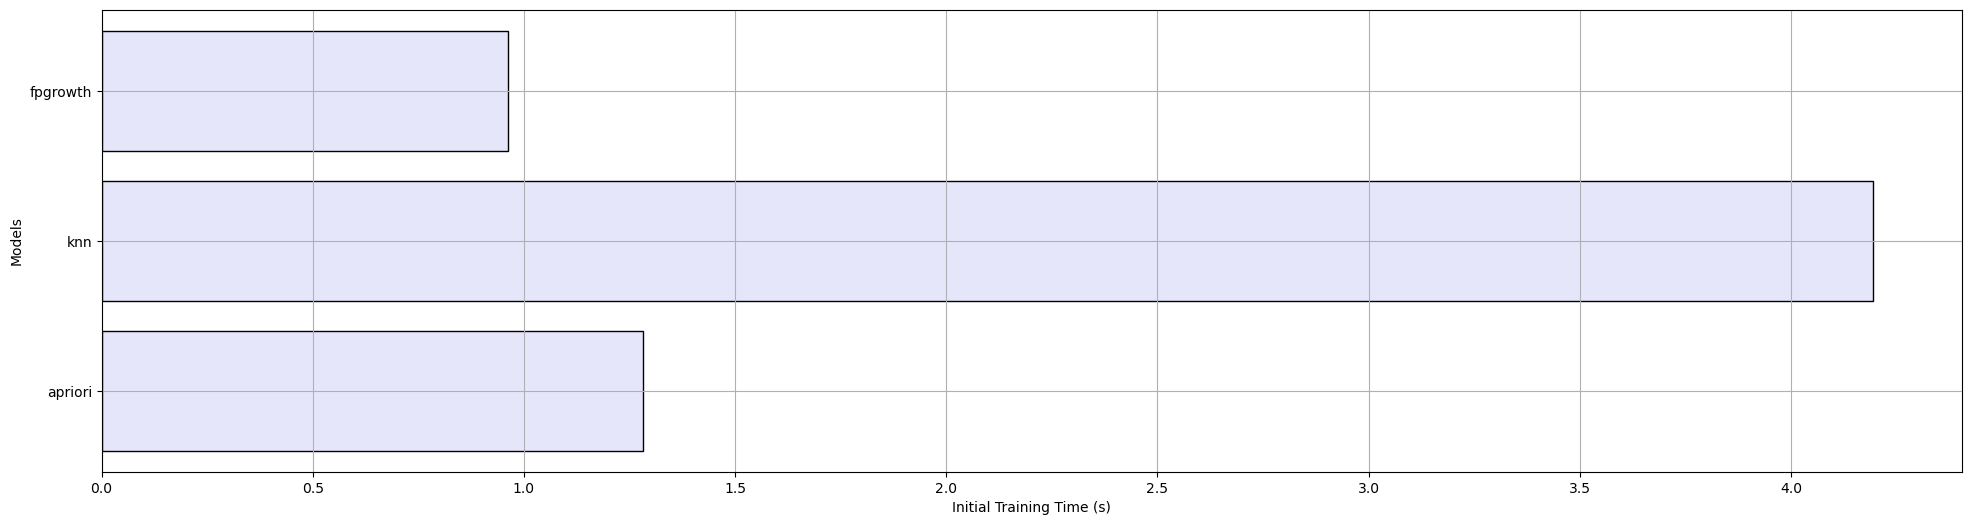

In [69]:
plt.figure(figsize=(24,6))
plt.barh(Time_Analysis['model'], Time_Analysis['train_time'], color='lavender', edgecolor='black')
plt.grid()
plt.ylabel("Models")
plt.xlabel("Initial Training Time (s)")
plt.show()


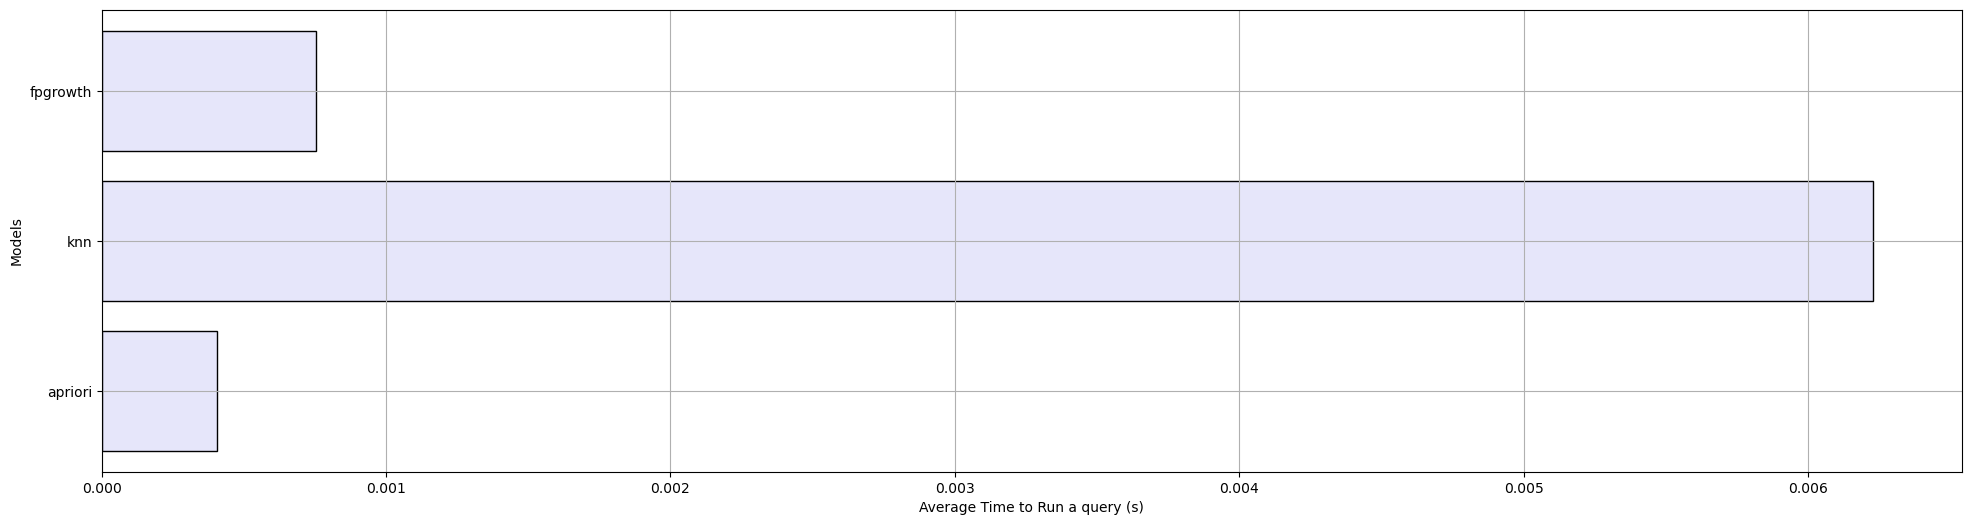

In [70]:
plt.figure(figsize=(24,6))
plt.barh(Time_Analysis['model'], Time_Analysis['q_time'], color='lavender', edgecolor='black')
plt.grid()
plt.ylabel("Models")
plt.xlabel("Average Time to Run a query (s)")
plt.show()


In [71]:
Time_Analysis[['model','q_time','train_time']]

,model,q_time,train_time
0,apriori,0.000404,1.282116
1,knn,0.006229,4.194543
2,fpgrowth,0.000754,0.962219


***

MEAN Average PRECISION mAP

In [74]:
def mAP(lst, GT):
    mAP = 0.0
    c = 0
    for i, item in enumerate(lst):
        if item in GT:
            c+=1
            mAP += c / (i + 1)
    if len(lst) == 0:
        return 0.0
    return mAP / len(lst)

def test_recommedations(model):
    # Ground Truth 
    train_data = pd.read_csv('Groceries data train.csv')
    ground_truth = [tuple(a[1]['itemDescription'].tolist()) for a in list(train_data.groupby(['Member_number', 'Date']))]
    test_data = pd.read_csv('Groceries data test.csv')
    map_sum = 0 
    length = 0
    user_item_dict = {}
    for row in test_data.iterrows():
        user = str(row[1]['Date'])+"_on_"+str(row[1]['Member_number'])
        #print(user)
        if user not in user_item_dict:
            user_item_dict[user] = [row[1]['itemDescription']]
        else:
            user_item_dict[user].append(row[1]['itemDescription'])
    for user, items in user_item_dict.items():
        # Generate recommendations
        GT = set()
        for item in items:
            GT.add(item)
            for g in ground_truth:
                if item in g:
                    GT = GT.union(set(g))
        for item in items:
            recommendations = model.recommend(item)
            length += 1
            map_sum += mAP(recommendations, GT)
        # Generate recommendations
        recommendations = model.recommend(items)
        # Calculate precision
        map_sum += mAP(recommendations, GT)
        # Add to mean absolute precision
        length += 1
    map = map_sum / length
    return map

print("#"*20+ " Mean Average Precision of the models "+"#"*20)
print(f"Apriori : {test_recommedations(Apriori)}")
print(f"FP Growth : {test_recommedations(fpg)}")
print(f"K nearest neighbour : {test_recommedations(knn)}")

#################### Mean Average Precision of the models ####################
Apriori : 0.2510468400038952
FP Growth : 0.2510468400038952
K nearest neighbour : 0.9438245741702361


ANALYSIS FOR MEAN AVERAGE PRECISION

The results of the mean average precision analysis show that the K nearest neighbour model has significantly higher accuracy than the other two models. The Apriori and FP Growth models have the same accuracy score, which is lower than that of the K nearest neighbour model. This suggests that the K nearest neighbour model may be the best option for generating accurate product recommendations for grocery customers.

***
MMR

In [73]:
def MMR(lst, GT):
    mmr = 0.0
    for i, item in enumerate(lst):
        if item in GT:
            mmr = 1 / (i + 1)
            break
    return mmr

def test_mmr(model):
    # Ground Truth 
    train_data = pd.read_csv('Groceries data train.csv')
    ground_truth = [tuple(a[1]['itemDescription'].tolist()) for a in list(train_data.groupby(['Member_number', 'Date']))]
    test_data = pd.read_csv('Groceries data test.csv')
    map_sum = 0 
    length = 0
    user_item_dict = {}
    for row in test_data.iterrows():
        user = str(row[1]['Date'])+"_on_"+str(row[1]['Member_number'])
        #print(user)
        if user not in user_item_dict:
            user_item_dict[user] = [row[1]['itemDescription']]
        else:
            user_item_dict[user].append(row[1]['itemDescription'])
    for user, items in user_item_dict.items():
        # Generate recommendations
        GT = set()
        for item in items:
            GT.add(item)
            for g in ground_truth:
                if item in g:
                    GT = GT.union(set(g))
        for item in items:
            recommendations = model.recommend(item)
            # Calculate accuracy
            map_sum+= MMR(recommendations, GT)
            # Add to mean absolute precision
            length += 1
        # Generate recommendations
        recommendations = model.recommend(items)
        # Calculate precision
        map_sum+= MMR(recommendations, GT)
        # Add to mean absolute precision
        length += 1
    map = map_sum / length
    return map

print("#"*20+ " Mean Reciprocal Rank (MRR) of the models "+"#"*20)
print(f"Apriori : {test_mmr(Apriori)}")
print(f"FP Growth : {test_mmr(fpg)}")
print(f"K nearest neighbour : {test_mmr(knn)}")

#################### Mean Reciprocal Rank (MRR) of the models ####################
Apriori : 0.2510468400038952
FP Growth : 0.2510468400038952
K nearest neighbour : 0.9817622618236099


ANALYSIS OF MMR

The three models have different MRR scores, which indicate their ability to make accurate recommendations. Both Apriori and FP Growth have the same score, which is considerably lower than the K Nearest Neighbour model. This suggests that the association rule mining techniques used by Apriori and FP Growth may not be as effective for this particular dataset, while the KNN model performs better in terms of recommending items that the user is likely to purchase. Therefore, the KNN model could be a better choice for making personalized recommendations to users.

## Final Thoughts

The results of the evaluation show that the K-Nearest Neighbour (KNN) model outperforms both the Apriori and FP-Growth models for both mean average precision (MAP) and mean reciprocal rank (MRR) metrics. The MAP values for Apriori and FP-Growth are identical, indicating that they performed similarly in terms of precision, while KNN achieved a much higher MAP score of 0.943. Similarly, the MRR score for KNN is much higher than the other two models, indicating that KNN performed better at identifying the most relevant item for a given user.

The results suggest that KNN is better suited to this task than the Apriori and FP-Growth models. This is likely because KNN is able to take into account user-item interactions, whereas the other two models rely solely on item-item associations. Additionally, the fact that KNN achieves a significantly higher MRR score indicates that it is better at identifying the most relevant item for each user, which is the ultimate goal of a recommendation system.